# Phase 4: 4D Parameter Space Visualization

Visualizing the full 4D parameter space (prey_birth, prey_death, pred_birth, pred_death).

## Visualization Techniques for 4D:
1. **3D Scatter + Color**: 3 axes for parameters, color for 4th parameter or outcome
2. **Parallel Coordinates**: Each parameter as a vertical axis, lines connect values
3. **Interactive 3D**: Rotate and explore with plotly


In [2]:
# Setup
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "scripts"))

from analysis import load_phase4_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100

print("✓ Setup complete")


✓ Setup complete


In [3]:
# Load data - UPDATE PATH!
results_dir = project_root / "hpc_data" / "phase4_18735304"  # <-- UPDATE THIS

if not results_dir.exists():
    print(f"⚠️  Update the path! Available:")
    for d in (project_root / "hpc_data").iterdir():
        if d.is_dir(): print(f"  - {d.name}")
    raise FileNotFoundError("Update results_dir above!")

results = load_phase4_results(results_dir)
df = pd.DataFrame(results)
print(f"✓ Loaded {len(df)} simulations")

# Compute outcome: coexistence
df['coexistence'] = (df['prey_survived'] == True) & (df['pred_survived'] == True)
df['coex_int'] = df['coexistence'].astype(int)

# Compute average cluster size from prey_cluster_sizes
import ast
def compute_avg_cluster_size(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except:
            return np.nan
    if isinstance(x, list) and len(x) > 0:
        return np.mean(x)
    return np.nan

df['avg_cluster_size'] = df['prey_cluster_sizes'].apply(compute_avg_cluster_size)

# Average over replicates for cleaner visualization
df_avg = df.groupby(['prey_birth', 'prey_death', 'predator_birth', 'predator_death']).agg({
    'prey_mean': 'mean',
    'pred_mean': 'mean',
    'coex_int': 'mean',
    'avg_cluster_size': 'mean'
}).reset_index()
df_avg['coexistence_rate'] = df_avg['coex_int'] * 100

print(f"✓ {len(df_avg)} unique parameter combinations")
print(f"✓ Avg cluster size range: [{df_avg['avg_cluster_size'].min():.1f}, {df_avg['avg_cluster_size'].max():.1f}]")


✓ Loaded 146410 simulations
✓ 14641 unique parameter combinations
✓ Avg cluster size range: [1.4, 62500.0]


📊 Parameter Space Overview:
   Prey birth: 11 values
   Prey death: 11 values
   Predator birth: 11 values
   Predator death: 11 values

   Total unique combinations: 14641
   Total possible combinations: 14641


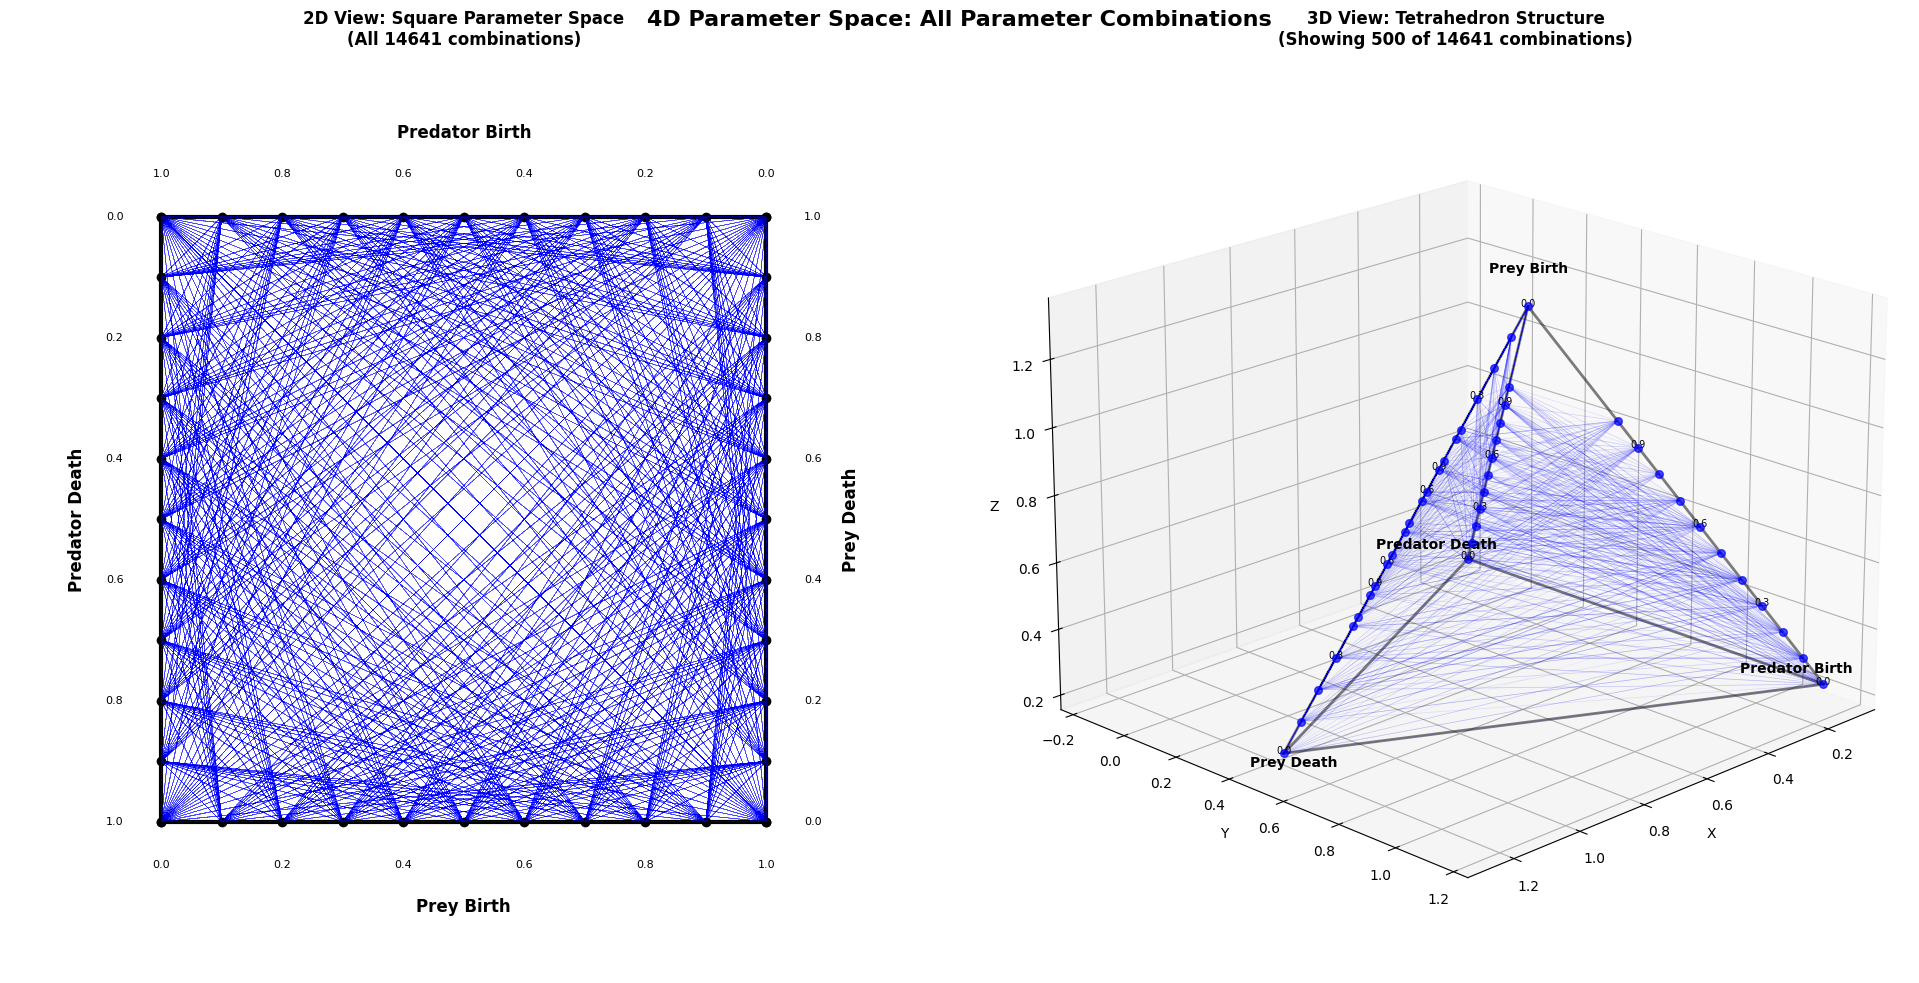


✓ Parameter space visualization complete (2D + 3D)
   2D: Square shows 4 parameters, each with 11 values
   3D: Tetrahedron structure showing parameter connections
   Lines connect parameters to show all combinations


In [20]:
# Visualize Parameter Space: Simple square plot showing all parameter combinations
# Each side of the square represents one parameter with its 11 values
# Lines connect parameters to show all possible combinations

# Get unique parameter values
prey_births = sorted(df['prey_birth'].unique())
prey_deaths = sorted(df['prey_death'].unique())
pred_births = sorted(df['predator_birth'].unique())
pred_deaths = sorted(df['predator_death'].unique())

print("📊 Parameter Space Overview:")
print(f"   Prey birth: {len(prey_births)} values")
print(f"   Prey death: {len(prey_deaths)} values")
print(f"   Predator birth: {len(pred_births)} values")
print(f"   Predator death: {len(pred_deaths)} values")
print(f"\n   Total unique combinations: {len(df_avg)}")
print(f"   Total possible combinations: {len(prey_births) * len(prey_deaths) * len(pred_births) * len(pred_deaths)}")

# Create plots: 2D and 3D views
fig = plt.figure(figsize=(20, 10))
fig.suptitle('4D Parameter Space: All Parameter Combinations', fontsize=16, fontweight='bold', y=0.98)

# 2D Plot (left)
ax = fig.add_subplot(121)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_aspect('equal')
ax.axis('off')

# Define square corners (centered at 0.5, 0.5)
square_size = 0.8
center = 0.5
half_size = square_size / 2

# Define the 4 sides of the square
# Side 1: Bottom (prey_birth) - left to right
# Side 2: Right (prey_death) - bottom to top
# Side 3: Top (predator_birth) - right to left
# Side 4: Left (predator_death) - top to bottom

# Normalize parameter values to [0, 1] range for positioning
def normalize_param(values):
    """Normalize parameter values to [0, 1]"""
    min_val, max_val = min(values), max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    return [(v - min_val) / (max_val - min_val) for v in values]

# Normalize all parameters
pb_norm = normalize_param(prey_births)
pd_norm = normalize_param(prey_deaths)
pred_b_norm = normalize_param(pred_births)
pred_d_norm = normalize_param(pred_deaths)

# Draw the square
square_x = [center - half_size, center + half_size, center + half_size, center - half_size, center - half_size]
square_y = [center - half_size, center - half_size, center + half_size, center + half_size, center - half_size]
ax.plot(square_x, square_y, 'k-', linewidth=3, label='Parameter Space')

# Draw parameter axes and labels
# Bottom side: Prey Birth (left to right)
for i, val in enumerate(prey_births):
    x_pos = center - half_size + pb_norm[i] * square_size
    y_pos = center - half_size
    ax.plot(x_pos, y_pos, 'ko', markersize=6)
    if i % 2 == 0:  # Label every other value to avoid crowding
        ax.text(x_pos, y_pos - 0.05, f'{val:.1f}', ha='center', va='top', fontsize=8)
ax.text(center, center - half_size - 0.1, 'Prey Birth', ha='center', va='top', 
        fontsize=12, fontweight='bold')

# Right side: Prey Death (bottom to top)
for i, val in enumerate(prey_deaths):
    x_pos = center + half_size
    y_pos = center - half_size + pd_norm[i] * square_size
    ax.plot(x_pos, y_pos, 'ko', markersize=6)
    if i % 2 == 0:
        ax.text(x_pos + 0.05, y_pos, f'{val:.1f}', ha='left', va='center', fontsize=8)
ax.text(center + half_size + 0.1, center, 'Prey Death', ha='left', va='center', 
        fontsize=12, fontweight='bold', rotation=90)

# Top side: Predator Birth (right to left)
for i, val in enumerate(pred_births):
    x_pos = center + half_size - pred_b_norm[i] * square_size
    y_pos = center + half_size
    ax.plot(x_pos, y_pos, 'ko', markersize=6)
    if i % 2 == 0:
        ax.text(x_pos, y_pos + 0.05, f'{val:.1f}', ha='center', va='bottom', fontsize=8)
ax.text(center, center + half_size + 0.1, 'Predator Birth', ha='center', va='bottom', 
        fontsize=12, fontweight='bold')

# Left side: Predator Death (top to bottom)
for i, val in enumerate(pred_deaths):
    x_pos = center - half_size
    y_pos = center + half_size - pred_d_norm[i] * square_size
    ax.plot(x_pos, y_pos, 'ko', markersize=6)
    if i % 2 == 0:
        ax.text(x_pos - 0.05, y_pos, f'{val:.1f}', ha='right', va='center', fontsize=8)
ax.text(center - half_size - 0.1, center, 'Predator Death', ha='right', va='center', 
        fontsize=12, fontweight='bold', rotation=90)

# Draw lines connecting all combinations
# Show all combinations with very light lines to show the full parameter space
for idx, row in df_avg.iterrows():
    # Get normalized positions for each parameter
    pb_idx = prey_births.index(row['prey_birth'])
    pd_idx = prey_deaths.index(row['prey_death'])
    pred_b_idx = pred_births.index(row['predator_birth'])
    pred_d_idx = pred_deaths.index(row['predator_death'])
    
    # Calculate positions on square sides
    pb_x = center - half_size + pb_norm[pb_idx] * square_size
    pb_y = center - half_size
    
    pd_x = center + half_size
    pd_y = center - half_size + pd_norm[pd_idx] * square_size
    
    pred_b_x = center + half_size - pred_b_norm[pred_b_idx] * square_size
    pred_b_y = center + half_size
    
    pred_d_x = center - half_size
    pred_d_y = center + half_size - pred_d_norm[pred_d_idx] * square_size
    
    # Draw lines connecting all 4 parameters (forming a quadrilateral)
    ax.plot([pb_x, pd_x, pred_b_x, pred_d_x, pb_x], 
            [pb_y, pd_y, pred_b_y, pred_d_y, pb_y],
            'b-', alpha=0.02, linewidth=0.3)

ax.set_title('2D View: Square Parameter Space\n' + 
             f'(All {len(df_avg)} combinations)', 
             fontsize=12, fontweight='bold', pad=15)

# 3D Plot (right)
ax3d = fig.add_subplot(122, projection='3d')

# Create a tetrahedron-like structure in 3D
# Place 4 parameters at vertices of a tetrahedron
# We'll use a regular tetrahedron centered at origin

# Tetrahedron vertices (normalized)
tetra_vertices = np.array([
    [0, 0, 1],           # Vertex 1: Prey Birth (top)
    [0.9428, 0, -0.3333], # Vertex 2: Prey Death (front-right)
    [-0.4714, 0.8165, -0.3333], # Vertex 3: Predator Birth (back-left)
    [-0.4714, -0.8165, -0.3333] # Vertex 4: Predator Death (back-right)
])

# Scale and center
scale = 0.8
center_3d = np.array([0.5, 0.5, 0.5])
vertices_3d = center_3d + scale * tetra_vertices

# Draw tetrahedron edges
edges = [
    [0, 1], [0, 2], [0, 3],  # From vertex 0
    [1, 2], [1, 3],          # Between bottom vertices
    [2, 3]                    # Bottom edge
]

for edge in edges:
    v1, v2 = vertices_3d[edge[0]], vertices_3d[edge[1]]
    ax3d.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], 
              'k-', linewidth=2, alpha=0.5)

# Map parameters to vertices
param_to_vertex = {
    'prey_birth': 0,
    'prey_death': 1,
    'predator_birth': 2,
    'predator_death': 3
}

# Draw parameter values along edges
# For each parameter, draw points along the edges from that vertex
def draw_param_on_edge(ax3d, vertex_idx, param_values, param_norm, vertices_3d, label):
    """Draw parameter values along edges from a vertex."""
    vertex = vertices_3d[vertex_idx]
    
    # Find edges connected to this vertex
    connected_vertices = [i for i in range(4) if i != vertex_idx]
    
    # Draw points along the first edge (to first connected vertex)
    if len(connected_vertices) > 0:
        target_vertex = vertices_3d[connected_vertices[0]]
        edge_vec = target_vertex - vertex
        
        for i, val in enumerate(param_values):
            # Position along edge (0 = at vertex, 1 = at target)
            pos = param_norm[i] * 0.7  # Scale to 70% of edge length
            point = vertex + pos * edge_vec
            ax3d.scatter([point[0]], [point[1]], [point[2]], 
                        c='blue', s=30, alpha=0.7)
            if i % 3 == 0:  # Label every 3rd value
                ax3d.text(point[0], point[1], point[2], f'{val:.1f}', 
                         fontsize=7, ha='center')

# Draw parameters
draw_param_on_edge(ax3d, 0, prey_births, pb_norm, vertices_3d, 'Prey Birth')
draw_param_on_edge(ax3d, 1, prey_deaths, pd_norm, vertices_3d, 'Prey Death')
draw_param_on_edge(ax3d, 2, pred_births, pred_b_norm, vertices_3d, 'Predator Birth')
draw_param_on_edge(ax3d, 3, pred_deaths, pred_d_norm, vertices_3d, 'Predator Death')

# Draw connections (sample to avoid overcrowding)
sample_size_3d = min(500, len(df_avg))
df_sample_3d = df_avg.sample(sample_size_3d, random_state=42) if len(df_avg) > sample_size_3d else df_avg

for idx, row in df_sample_3d.iterrows():
    # Get positions for each parameter
    pb_idx = prey_births.index(row['prey_birth'])
    pd_idx = prey_deaths.index(row['prey_death'])
    pred_b_idx = pred_births.index(row['predator_birth'])
    pred_d_idx = pred_deaths.index(row['predator_death'])
    
    # Calculate 3D positions
    v0 = vertices_3d[0] + pb_norm[pb_idx] * 0.7 * (vertices_3d[1] - vertices_3d[0])
    v1 = vertices_3d[1] + pd_norm[pd_idx] * 0.7 * (vertices_3d[0] - vertices_3d[1])
    v2 = vertices_3d[2] + pred_b_norm[pred_b_idx] * 0.7 * (vertices_3d[0] - vertices_3d[2])
    v3 = vertices_3d[3] + pred_d_norm[pred_d_idx] * 0.7 * (vertices_3d[0] - vertices_3d[3])
    
    # Draw lines connecting all 4 parameters
    points = np.array([v0, v1, v2, v3, v0])
    ax3d.plot(points[:, 0], points[:, 1], points[:, 2], 
              'b-', alpha=0.05, linewidth=0.5)

# Add labels
ax3d.text(vertices_3d[0][0], vertices_3d[0][1], vertices_3d[0][2] + 0.1, 
          'Prey Birth', fontsize=10, fontweight='bold', ha='center')
ax3d.text(vertices_3d[1][0] + 0.1, vertices_3d[1][1], vertices_3d[1][2], 
          'Prey Death', fontsize=10, fontweight='bold', ha='left')
ax3d.text(vertices_3d[2][0] - 0.1, vertices_3d[2][1], vertices_3d[2][2], 
          'Predator Birth', fontsize=10, fontweight='bold', ha='right')
ax3d.text(vertices_3d[3][0] - 0.1, vertices_3d[3][1], vertices_3d[3][2], 
          'Predator Death', fontsize=10, fontweight='bold', ha='right')

ax3d.set_xlabel('X', fontsize=10)
ax3d.set_ylabel('Y', fontsize=10)
ax3d.set_zlabel('Z', fontsize=10)
ax3d.set_title(f'3D View: Tetrahedron Structure\n' + 
               f'(Showing {len(df_sample_3d)} of {len(df_avg)} combinations)', 
               fontsize=12, fontweight='bold', pad=15)
ax3d.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\n✓ Parameter space visualization complete (2D + 3D)")
print(f"   2D: Square shows 4 parameters, each with 11 values")
print(f"   3D: Tetrahedron structure showing parameter connections")
print(f"   Lines connect parameters to show all combinations")


---

# Phase 1: Visualizing Hydra Effect Curves

**Goal**: For each combination of (prey_birth, predator_birth, predator_death), visualize the equilibrium prey population vs prey_death to identify where the hydra effect occurs.

**What we expect**: In some parameter combinations, we should see the hydra effect - where prey population *increases* as prey_death (mortality) increases. This appears as an upward-sloping region in the curve.

**Approach**:
- Group data by (prey_birth, predator_birth, predator_death)
- For each group, plot: **prey_mean vs prey_death**
- Look for curves with increasing regions (hydra effect)


In [4]:
# Phase 1: Plot equilibrium prey density vs prey_death for each parameter combination

# Get grid_size from the data (should be consistent across all simulations)
if 'grid_size' in df.columns:
    grid_size = df['grid_size'].iloc[0]  # Get grid size from first row
else:
    # Try to get it from the original results
    grid_size = results[0].get('grid_size', 250)  # Default fallback

print(f"Grid size: {grid_size}x{grid_size}")
area = grid_size * grid_size  # Total area of the grid

# Compute prey density = population / area
df_avg['prey_density'] = df_avg['prey_mean'] / area

# Get unique parameter values
prey_births = sorted(df_avg['prey_birth'].unique())
prey_deaths = sorted(df_avg['prey_death'].unique())
pred_births = sorted(df_avg['predator_birth'].unique())
pred_deaths = sorted(df_avg['predator_death'].unique())

print(f"Parameter space:")
print(f"  Prey birth: {len(prey_births)} values")
print(f"  Prey death: {len(prey_deaths)} values")
print(f"  Predator birth: {len(pred_births)} values")
print(f"  Predator death: {len(pred_deaths)} values")
print(f"\nTotal combinations: {len(prey_births) * len(pred_births) * len(pred_deaths)}")

# Group by (prey_birth, predator_birth, predator_death)
grouped = df_avg.groupby(['prey_birth', 'predator_birth', 'predator_death'])

# Prepare data for plotting (using density instead of population)
curves_data = []
for (pb, pred_b, pred_d), group in grouped:
    # Sort by prey_death for proper curve plotting
    group_sorted = group.sort_values('prey_death')
    curves_data.append({
        'prey_birth': pb,
        'predator_birth': pred_b,
        'predator_death': pred_d,
        'prey_death': group_sorted['prey_death'].values,
        'prey_density': group_sorted['prey_density'].values,
        'prey_mean': group_sorted['prey_mean'].values,  # Keep for reference
        'n_points': len(group_sorted)
    })

print(f"✓ Prepared {len(curves_data)} curves")
print(f"  Average points per curve: {np.mean([c['n_points'] for c in curves_data]):.1f}")
print(f"  Prey density range: [{df_avg['prey_density'].min():.4f}, {df_avg['prey_density'].max():.4f}]")


Grid size: 250x250
Parameter space:
  Prey birth: 11 values
  Prey death: 11 values
  Predator birth: 11 values
  Predator death: 11 values

Total combinations: 1331
✓ Prepared 1331 curves
  Average points per curve: 11.0
  Prey density range: [0.0000, 1.0000]


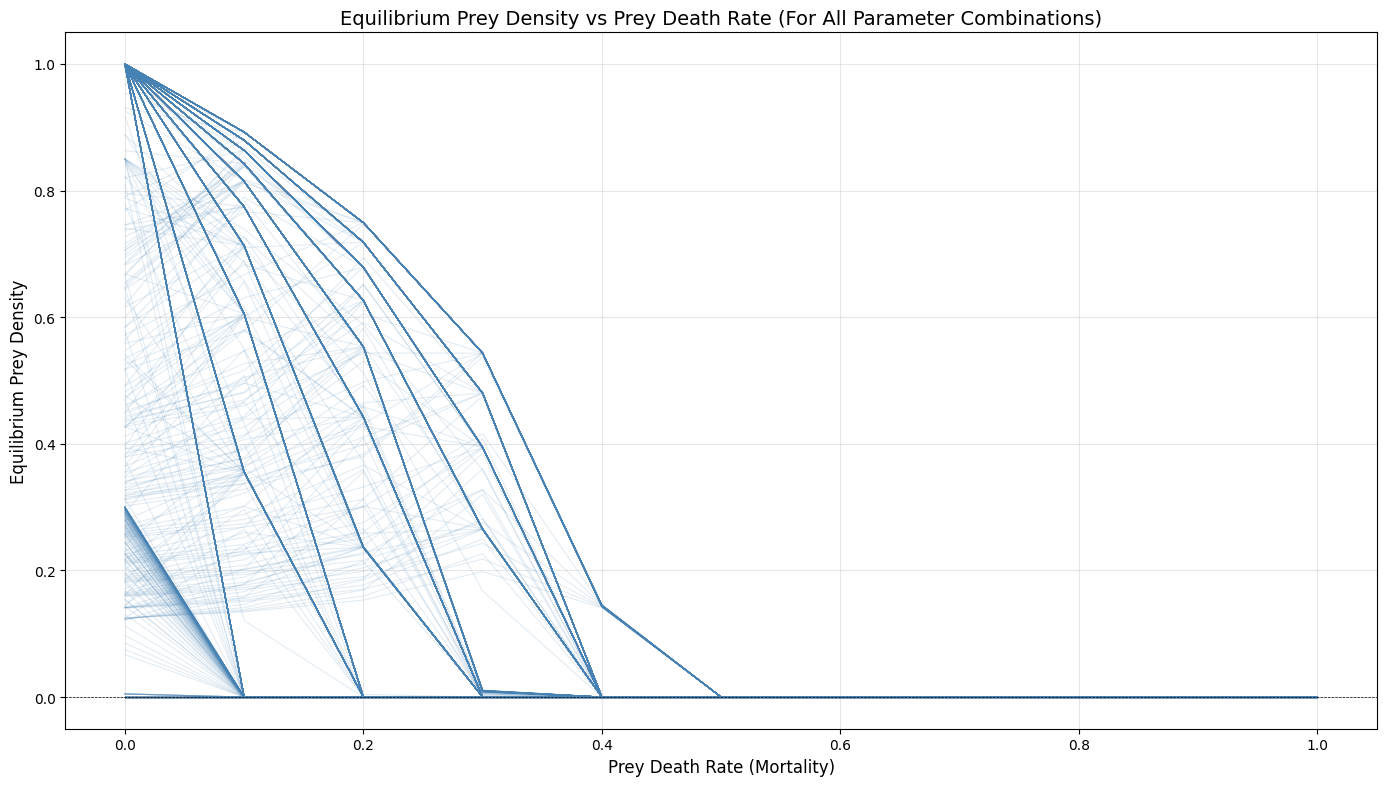

📊 Plotted 1331 curves
💡 Look for upward-sloping regions (hydra effect) where density increases with mortality


In [6]:
# Plot 1: Overview - All curves overlaid (with transparency)
fig, ax = plt.subplots(figsize=(14, 8))

for curve in curves_data:
    ax.plot(curve['prey_death'], curve['prey_density'], 
            alpha=0.15, linewidth=0.8, color='steelblue')

ax.set_xlabel('Prey Death Rate (Mortality)', fontsize=12)
ax.set_ylabel('Equilibrium Prey Density', fontsize=12)
ax.set_title('Equilibrium Prey Density vs Prey Death Rate (For All Parameter Combinations)', 
             fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"📊 Plotted {len(curves_data)} curves")
print(f"💡 Look for upward-sloping regions (hydra effect) where density increases with mortality")


📊 Curve Classification:
   Curves WITH hydra effect: 135 (10.1%)
   Curves WITHOUT hydra effect: 1196 (89.9%)


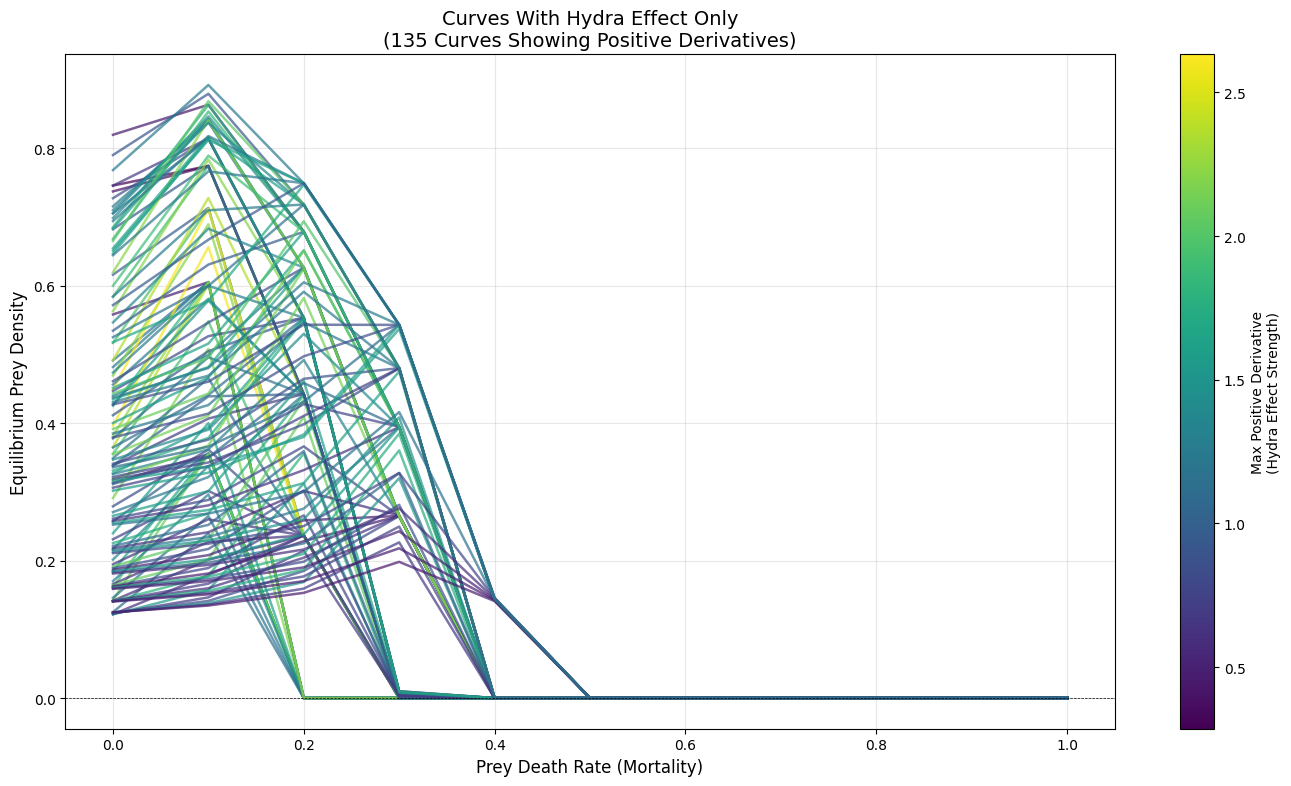


✓ Filtered: Showing only 135 curves with hydra effect


In [7]:
# Plot 2: Identify and highlight curves with hydra effect
# Hydra effect = region where density increases with mortality (positive derivative)

def detect_hydra_effect(prey_death, prey_density):
    """Detect if curve has hydra effect (increasing region)."""
    if len(prey_death) < 2:
        return False, None
    
    # Compute derivative
    derivatives = np.diff(prey_density) / np.diff(prey_death)
    
    # Check if any derivative is positive (increasing)
    has_increasing = np.any(derivatives > 0)
    
    if has_increasing:
        # Find the maximum positive derivative (strongest hydra effect)
        max_deriv_idx = np.argmax(derivatives)
        max_deriv = derivatives[max_deriv_idx]
        return True, max_deriv
    return False, None

# Classify curves
curves_with_hydra = []
curves_without_hydra = []

for curve in curves_data:
    has_hydra, max_deriv = detect_hydra_effect(curve['prey_death'], curve['prey_density'])
    curve['has_hydra'] = has_hydra
    curve['max_derivative'] = max_deriv
    
    if has_hydra:
        curves_with_hydra.append(curve)
    else:
        curves_without_hydra.append(curve)

print(f"📊 Curve Classification:")
print(f"   Curves WITH hydra effect: {len(curves_with_hydra)} ({100*len(curves_with_hydra)/len(curves_data):.1f}%)")
print(f"   Curves WITHOUT hydra effect: {len(curves_without_hydra)} ({100*len(curves_without_hydra)/len(curves_data):.1f}%)")

# Plot: Show ONLY curves with hydra effect (filtered)
fig, ax = plt.subplots(figsize=(14, 8))

# Plot ONLY curves with hydra effect (colored by strength)
if len(curves_with_hydra) > 0:
    max_derivs = [c['max_derivative'] for c in curves_with_hydra]
    norm = plt.Normalize(vmin=min(max_derivs), vmax=max(max_derivs))
    cmap = plt.cm.viridis
    
    for curve in curves_with_hydra:
        color = cmap(norm(curve['max_derivative']))
        ax.plot(curve['prey_death'], curve['prey_density'], 
                alpha=0.7, linewidth=1.8, color=color)
    
    ax.set_xlabel('Prey Death Rate (Mortality)', fontsize=12)
    ax.set_ylabel('Equilibrium Prey Density', fontsize=12)
    ax.set_title(f'Curves With Hydra Effect Only\n({len(curves_with_hydra)} Curves Showing Positive Derivatives)', 
                 fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    
    # Add colorbar for hydra effect strength
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Max Positive Derivative\n(Hydra Effect Strength)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Filtered: Showing only {len(curves_with_hydra)} curves with hydra effect")
else:
    print("⚠️  No curves with hydra effect found!")


📊 Filtered Curves:
   Original curves: 135
   Filtered curves: 135
   Average points kept: 2.7 out of 11.0 (24.1%)


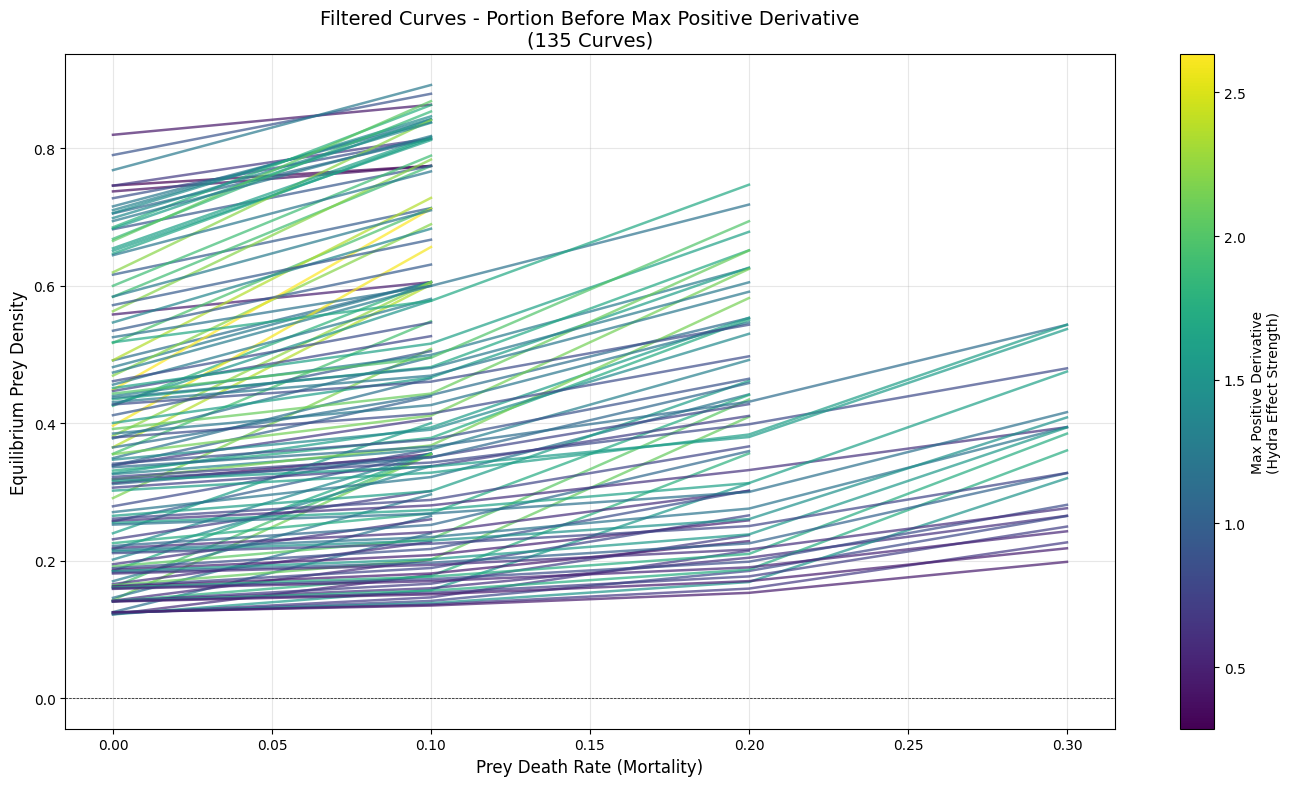


✓ Filtered: Showing only portion before (to the left of) maximum positive derivative for each curve


In [9]:
# Filter curves: Show only portion BEFORE (to the left of) maximum positive derivative
# For each curve, find where max derivative occurs and keep only points up to that point

filtered_curves = []

for curve in curves_with_hydra:
    prey_d = curve['prey_death']
    prey_n = curve['prey_density']  # Use density instead of population
    
    # Compute derivatives
    derivatives = np.diff(prey_n) / np.diff(prey_d)
    
    # Find index of maximum positive derivative
    max_deriv_idx = np.argmax(derivatives)
    
    # Keep only points up to and including the point AFTER max derivative
    # (derivatives[i] is between point i and i+1, so we keep up to i+1)
    end_idx = max_deriv_idx + 1
    
    if end_idx > 0:
        filtered_curves.append({
            'prey_birth': curve['prey_birth'],
            'predator_birth': curve['predator_birth'],
            'predator_death': curve['predator_death'],
            'prey_death': prey_d[:end_idx+1],  # Keep from start up to end_idx (inclusive)
            'prey_density': prey_n[:end_idx+1],  # Use density
            'max_derivative': curve['max_derivative'],
            'original_length': len(prey_d),
            'filtered_length': len(prey_d[:end_idx+1])
        })

print(f"📊 Filtered Curves:")
print(f"   Original curves: {len(curves_with_hydra)}")
print(f"   Filtered curves: {len(filtered_curves)}")
if len(filtered_curves) > 0:
    avg_kept = np.mean([c['filtered_length'] for c in filtered_curves])
    avg_original = np.mean([c['original_length'] for c in filtered_curves])
    print(f"   Average points kept: {avg_kept:.1f} out of {avg_original:.1f} ({100*avg_kept/avg_original:.1f}%)")

# Plot filtered curves
if len(filtered_curves) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    max_derivs = [c['max_derivative'] for c in filtered_curves]
    norm = plt.Normalize(vmin=min(max_derivs), vmax=max(max_derivs))
    cmap = plt.cm.viridis
    
    for curve in filtered_curves:
        color = cmap(norm(curve['max_derivative']))
        ax.plot(curve['prey_death'], curve['prey_density'], 
                alpha=0.7, linewidth=1.8, color=color)
    
    ax.set_xlabel('Prey Death Rate (Mortality)', fontsize=12)
    ax.set_ylabel('Equilibrium Prey Density', fontsize=12)
    ax.set_title(f'Filtered Curves - Portion Before Max Positive Derivative\n({len(filtered_curves)} Curves)', 
                 fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    
    # Add colorbar for hydra effect strength
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Max Positive Derivative\n(Hydra Effect Strength)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Filtered: Showing only portion before (to the left of) maximum positive derivative for each curve")
else:
    print("⚠️  No filtered curves to display!")


In [10]:
# Fit 2nd-degree polynomial to each truncated curve and extract quadratic coefficient
from numpy.polynomial import Polynomial

curves_with_quadratic_coef = []

for curve in filtered_curves:
    prey_d = curve['prey_death']
    prey_n = curve['prey_density']  # Use density instead of population
    
    # Need at least 3 points to fit a 2nd-degree polynomial
    if len(prey_d) < 3:
        curves_with_quadratic_coef.append({
            'prey_birth': curve['prey_birth'],
            'predator_birth': curve['predator_birth'],
            'predator_death': curve['predator_death'],
            'quadratic_coef': np.nan,
            'n_points': len(prey_d)
        })
        continue
    
    # Fit 2nd-order polynomial: N = a + b·prey_death + c·prey_death²
    try:
        poly = Polynomial.fit(prey_d, prey_n, deg=2)
        coeffs = poly.convert().coef  # Convert to standard form
        # coeffs[0] = constant, coeffs[1] = linear, coeffs[2] = quadratic
        quadratic_coef = coeffs[2] if len(coeffs) > 2 else 0.0
        
        curves_with_quadratic_coef.append({
            'prey_birth': curve['prey_birth'],
            'predator_birth': curve['predator_birth'],
            'predator_death': curve['predator_death'],
            'quadratic_coef': quadratic_coef,
            'n_points': len(prey_d),
            'max_derivative': curve['max_derivative']
        })
    except Exception as e:
        curves_with_quadratic_coef.append({
            'prey_birth': curve['prey_birth'],
            'predator_birth': curve['predator_birth'],
            'predator_death': curve['predator_death'],
            'quadratic_coef': np.nan,
            'n_points': len(prey_d),
            'max_derivative': curve['max_derivative']
        })

# Convert to DataFrame for easier analysis
df_quadratic = pd.DataFrame(curves_with_quadratic_coef)

# Filter out NaN values
df_quadratic_valid = df_quadratic[df_quadratic['quadratic_coef'].notna()]

print(f"📊 Polynomial Fitting Results:")
print(f"   Total curves: {len(curves_with_quadratic_coef)}")
print(f"   Valid fits: {len(df_quadratic_valid)} ({100*len(df_quadratic_valid)/len(curves_with_quadratic_coef):.1f}%)")
if len(df_quadratic_valid) > 0:
    print(f"   Quadratic coefficient range: [{df_quadratic_valid['quadratic_coef'].min():.2e}, {df_quadratic_valid['quadratic_coef'].max():.2e}]")
    print(f"   Mean quadratic coefficient: {df_quadratic_valid['quadratic_coef'].mean():.2e}")
    print(f"   Median quadratic coefficient: {df_quadratic_valid['quadratic_coef'].median():.2e}")

# Display first few results
print(f"\n📋 Sample Results (first 10):")
print(df_quadratic_valid[['prey_birth', 'predator_birth', 'predator_death', 'quadratic_coef', 'n_points']].head(10).to_string(index=False))


📊 Polynomial Fitting Results:
   Total curves: 135
   Valid fits: 64 (47.4%)
   Quadratic coefficient range: [8.86e-01, 8.52e+00]
   Mean quadratic coefficient: 3.56e+00
   Median quadratic coefficient: 3.31e+00

📋 Sample Results (first 10):
 prey_birth  predator_birth  predator_death  quadratic_coef  n_points
        0.5             0.5             0.1        3.463457         3
        0.5             0.6             0.1        6.458270         3
        0.5             0.7             0.1        8.160922         3
        0.5             0.8             0.1        8.518965         3
        0.5             0.9             0.1        7.087761         3
        0.5             1.0             0.1        5.992430         3
        0.6             0.4             0.1        6.219136         3
        0.6             0.5             0.1        6.224562         3
        0.6             0.6             0.1        3.830222         3
        0.6             0.7             0.1        2.85098

/var/folders/vm/t3wxkm516_b_b9g879dflw400000gn/T/ipykernel_35319/1306275352.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


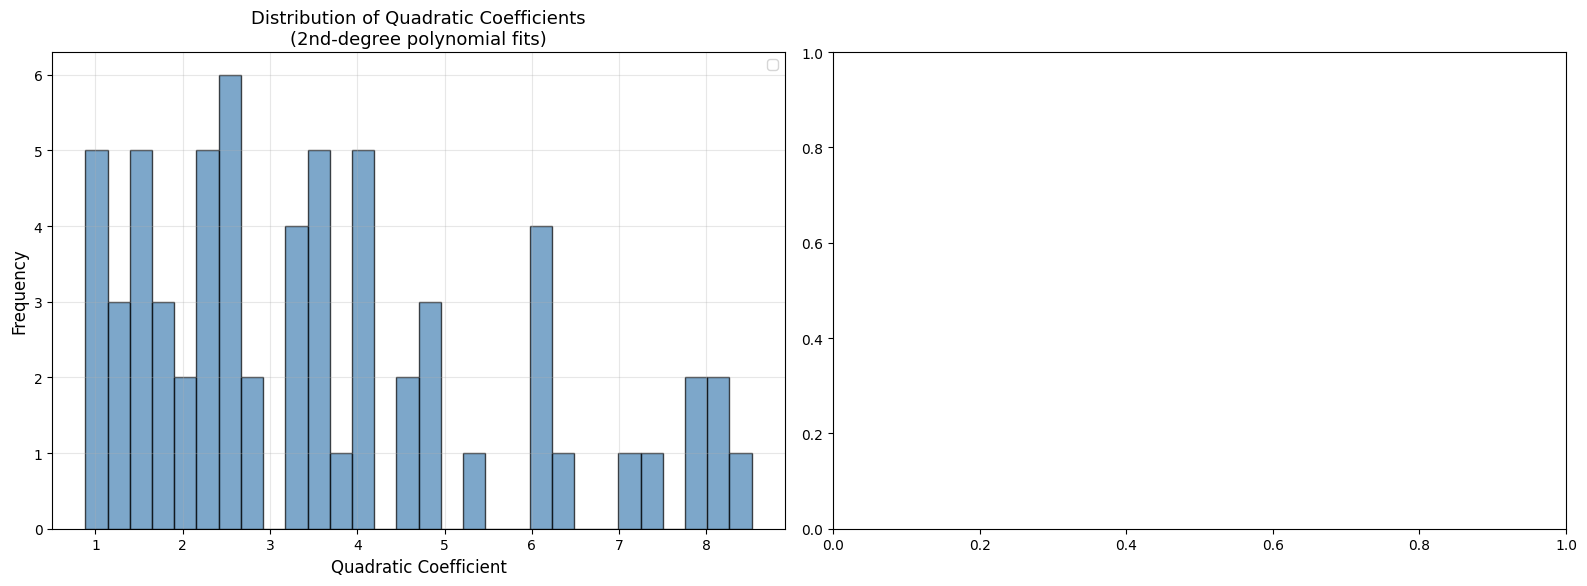


✓ Quadratic coefficients computed and visualized
   Positive coefficients indicate upward curvature (accelerating increase)
   Negative coefficients indicate downward curvature (decelerating increase)


In [17]:
# Visualize the quadratic coefficients
if len(df_quadratic_valid) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Histogram of quadratic coefficients
    ax1 = axes[0]
    ax1.hist(df_quadratic_valid['quadratic_coef'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Quadratic Coefficient', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Quadratic Coefficients\n(2nd-degree polynomial fits)', fontsize=13)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Quadratic coefficients computed and visualized")
    print(f"   Positive coefficients indicate upward curvature (accelerating increase)")
    print(f"   Negative coefficients indicate downward curvature (decelerating increase)")
else:
    print("⚠️  No valid quadratic coefficients to visualize!")


📊 Creating 3D Heatmap:
   Prey birth: 6 values: [0.5 0.6 0.7 0.8 0.9 1. ]
   Predator birth: 8 values: [0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
   Predator death: 2 values: [0.1 0.2]
   Total grid points: 96
   Data points: 64


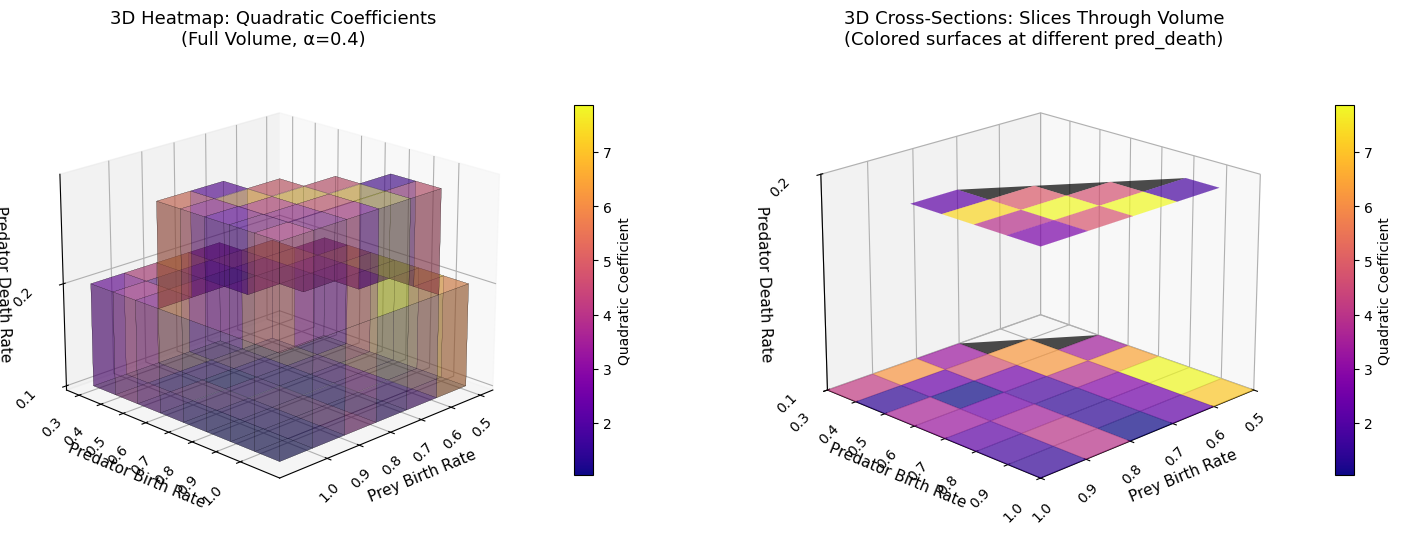


✓ 3D Heatmap created with transparency (α=0.4)
   Valid voxels (actual data points): 64 out of 96 total grid points
   Data coverage: 66.7%
   Quadratic coefficient range: [1.04e+00, 7.87e+00]
   💡 Only voxels with actual data are shown (NO interpolation)
   💡 Rotate plots interactively to explore the 3D parameter space


In [ ]:
# 3D Heatmap: Quadratic Coefficients
# Dimensions: prey_birth (X), predator_birth (Y), predator_death (Z)
# Heat: Quadratic coefficient
# NOTE: Only shows voxels where we have actual data (NO interpolation)

if len(df_quadratic_valid) > 0:
    # Get unique parameter values (should be 11 each)
    pb_grid = np.array(sorted(df_quadratic_valid['prey_birth'].unique()))
    pred_b_grid = np.array(sorted(df_quadratic_valid['predator_birth'].unique()))
    pred_d_grid = np.array(sorted(df_quadratic_valid['predator_death'].unique()))
    
    print(f"📊 Creating 3D Heatmap:")
    print(f"   Prey birth: {len(pb_grid)} values: {pb_grid}")
    print(f"   Predator birth: {len(pred_b_grid)} values: {pred_b_grid}")
    print(f"   Predator death: {len(pred_d_grid)} values: {pred_d_grid}")
    print(f"   Total grid points: {len(pb_grid) * len(pred_b_grid) * len(pred_d_grid)}")
    print(f"   Data points: {len(df_quadratic_valid)}")
    
    # Create 3D meshgrid
    PB, PRED_B, PRED_D = np.meshgrid(pb_grid, pred_b_grid, pred_d_grid, indexing='ij')
    
    # Directly map quadratic coefficients to grid points (NO interpolation)
    # Only fill grid points where we have actual data
    heatmap_3d = np.full(PB.shape, np.nan)
    
    # Map values directly to grid points
    for idx, row in df_quadratic_valid.iterrows():
        pb = row['prey_birth']
        pred_b = row['predator_birth']
        pred_d = row['predator_death']
        quad_coef = row['quadratic_coef']
        
        # Find indices in grid
        pb_idx = np.where(np.isclose(pb_grid, pb))[0]
        pred_b_idx = np.where(np.isclose(pred_b_grid, pred_b))[0]
        pred_d_idx = np.where(np.isclose(pred_d_grid, pred_d))[0]
        
        if len(pb_idx) > 0 and len(pred_b_idx) > 0 and len(pred_d_idx) > 0:
            heatmap_3d[pb_idx[0], pred_b_idx[0], pred_d_idx[0]] = quad_coef
    
    # Normalize values for colormap
    valid_mask = ~np.isnan(heatmap_3d)
    if np.any(valid_mask):
        vmin = np.nanpercentile(heatmap_3d, 5)
        vmax = np.nanpercentile(heatmap_3d, 95)
    else:
        vmin, vmax = 0, 1
    
    # Create voxel structure - only show voxels with valid data
    filled = ~np.isnan(heatmap_3d)
    
    # Normalize colors for the colormap
    colors = np.empty(heatmap_3d.shape + (4,))
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.plasma
    
    for i in range(heatmap_3d.shape[0]):
        for j in range(heatmap_3d.shape[1]):
            for k in range(heatmap_3d.shape[2]):
                if filled[i, j, k]:
                    # Get RGB color from colormap
                    rgb = cmap(norm(heatmap_3d[i, j, k]))[:3]
                    # Set alpha for transparency (0.4 = 40% opacity, 60% transparent)
                    colors[i, j, k] = [rgb[0], rgb[1], rgb[2], 0.4]
                else:
                    colors[i, j, k] = [0, 0, 0, 0]  # Fully transparent
    
    # Create 3D plot with transparency
    fig = plt.figure(figsize=(18, 8))
    
    # View 1: Full 3D volume
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.voxels(filled, facecolors=colors, edgecolors='k', linewidth=0.1, alpha=0.4)
    
    # Set axis ticks and labels to show ACTUAL parameter values
    ax1.set_xticks(range(len(pb_grid)))
    ax1.set_xticklabels([f'{x:.1f}' for x in pb_grid], rotation=45, ha='right')
    ax1.set_yticks(range(len(pred_b_grid)))
    ax1.set_yticklabels([f'{x:.1f}' for x in pred_b_grid], rotation=45, ha='right')
    ax1.set_zticks(range(len(pred_d_grid)))
    ax1.set_zticklabels([f'{x:.1f}' for x in pred_d_grid], rotation=45, ha='right')
    
    ax1.set_xlabel('Prey Birth Rate', fontsize=11)
    ax1.set_ylabel('Predator Birth Rate', fontsize=11)
    ax1.set_zlabel('Predator Death Rate', fontsize=11)
    ax1.set_title('3D Heatmap: Quadratic Coefficients\n(Full Volume, α=0.4)', 
                  fontsize=13)
    ax1.view_init(elev=20, azim=45)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar1 = plt.colorbar(sm, ax=ax1, shrink=0.6, pad=0.1)
    cbar1.set_label('Quadratic Coefficient', fontsize=10)
    
    # View 2: Cross-sections (3D surfaces showing slices through the volume)
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Show cross-sections at different predator_death values as 3D surfaces
    # Select a few representative slices
    n_slices = min(5, len(pred_d_grid))
    slice_indices = np.linspace(0, len(pred_d_grid)-1, n_slices, dtype=int)
    
    # Create meshgrid for 2D slices
    PB_slice, PRED_B_slice = np.meshgrid(pb_grid, pred_b_grid, indexing='ij')
    
    # Plot each slice as a 3D surface
    for idx, slice_idx in enumerate(slice_indices):
        pd_val = pred_d_grid[slice_idx]
        slice_data = heatmap_3d[:, :, slice_idx]
        
        # Mask out NaN values - only plot where we have data
        valid_mask = ~np.isnan(slice_data)
        
        if not np.any(valid_mask):
            continue  # Skip slices with no data
        
        # Create Z coordinate (constant for this slice)
        Z_slice = np.full_like(PB_slice, pd_val)
        
        # Create MASKED arrays - this prevents plot_surface from connecting NaN regions
        PB_masked = np.ma.masked_where(~valid_mask, PB_slice)
        PRED_B_masked = np.ma.masked_where(~valid_mask, PRED_B_slice)
        Z_masked = np.ma.masked_where(~valid_mask, Z_slice)
        
        # Create color array for valid points only
        face_colors = np.empty((*slice_data.shape, 4))
        for i in range(slice_data.shape[0]):
            for j in range(slice_data.shape[1]):
                if valid_mask[i, j]:
                    face_colors[i, j] = [*cmap(norm(slice_data[i, j]))[:3], 0.7]
                else:
                    face_colors[i, j] = [0, 0, 0, 0]  # Fully transparent
        
        # Plot as surface with masked arrays - this prevents connecting NaN regions
        surf = ax2.plot_surface(PB_masked, PRED_B_masked, Z_masked,
                               facecolors=face_colors,
                               alpha=0.7, linewidth=0.1, antialiased=True,
                               shade=False)
    
    # Set axis limits to actual parameter value ranges (not indices!)
    ax2.set_xlim(pb_grid.min(), pb_grid.max())
    ax2.set_ylim(pred_b_grid.min(), pred_b_grid.max())
    ax2.set_zlim(pred_d_grid.min(), pred_d_grid.max())
    
    # Set axis ticks and labels to show ACTUAL parameter values
    ax2.set_xticks(pb_grid)
    ax2.set_xticklabels([f'{x:.1f}' for x in pb_grid], rotation=45, ha='right')
    ax2.set_yticks(pred_b_grid)
    ax2.set_yticklabels([f'{x:.1f}' for x in pred_b_grid], rotation=45, ha='right')
    ax2.set_zticks(pred_d_grid)
    ax2.set_zticklabels([f'{x:.1f}' for x in pred_d_grid], rotation=45, ha='right')
    
    ax2.set_xlabel('Prey Birth Rate', fontsize=11)
    ax2.set_ylabel('Predator Birth Rate', fontsize=11)
    ax2.set_zlabel('Predator Death Rate', fontsize=11)
    ax2.set_title('3D Cross-Sections: Slices Through Volume\n(Colored surfaces at different pred_death)', 
                 fontsize=13)
    ax2.view_init(elev=20, azim=45)
    
    # Add colorbar
    sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm2.set_array([])
    cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.6, pad=0.1)
    cbar2.set_label('Quadratic Coefficient', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ 3D Heatmap created with transparency (α=0.4)")
    print(f"   Valid voxels (actual data points): {np.sum(filled)} out of {filled.size} total grid points")
    print(f"   Data coverage: {100*np.sum(filled)/filled.size:.1f}%")
    print(f"   Quadratic coefficient range: [{vmin:.2e}, {vmax:.2e}]")
    print(f"   💡 Only voxels with actual data are shown (NO interpolation)")
    print(f"   💡 Rotate plots interactively to explore the 3D parameter space")
else:
    print("⚠️  No valid quadratic coefficients to create heatmap!")


## 3. Self-Organized Criticality Across Parameter Regimes

**If evolution data is present**, analyze whether systems converge toward the critical point regardless of predator parameters.
